In [89]:
import torchvision
import argparse
import time 
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch.utils.data import Subset

In [90]:
class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img

In [91]:
class PIL2numpy:
    def __call__(self, img):
        return np.array(img)

In [92]:
class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr

In [93]:
class OneHot:
    def __init__(self, num_classes=10):
        self.num_classes = num_classes

    def __call__(self, target):
        one_hot_target = np.zeros(self.num_classes, dtype=np.float32)
        one_hot_target[target] = 1
        return one_hot_target

In [94]:
def get_axis_indexes(kernel_axis_length, center_index):
    axis_indexes = []
    for i in range(-center_index, kernel_axis_length - center_index):
        axis_indexes.append(i)
    return axis_indexes

In [95]:
def get_axes_indexes(kernel_size, kernel_center):
    indexes_a = get_axis_indexes(
        kernel_axis_length=kernel_size[0],
        center_index=kernel_center[0]
    )
    indexes_b = get_axis_indexes(
        kernel_axis_length=kernel_size[1],
        center_index=kernel_center[1]
    )
    return indexes_a, indexes_b

In [96]:
def load_weight_from_npy(weight_name, load_path):
    weight = np.load(load_path, allow_pickle=True).item().get(weight_name)
    return weight

In [97]:
class Conv2d:
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1,
        kernel_center=(0, 0), padding=0, convolution=False
    ):
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        if isinstance(kernel_size, tuple):
            self.kernel_size = kernel_size
        else:
            self.kernel_size = (kernel_size, kernel_size)
        self.kernel_center = kernel_center
        self.convolution = convolution
        self.padding = padding

        self.init_weights()

    def load_weights(self, weight_name, bias_name, load_path):
        self.conv_w = load_weight_from_npy(weight_name, load_path)
        self.conv_b = load_weight_from_npy(bias_name, load_path)

    def init_weights(self):
        self.conv_w = self.init_weight(self.kernel_size, self.in_channels*self.out_channels)
        self.conv_b = self.init_weight((1, 1), self.out_channels)

    def init_weight(self, weight_shape, weight_count):
        weight = []
        for i in range(weight_count):
            weight.append(2*np.random.random(weight_shape)-1)
        return weight

    def convolution_feed_x_l(self, y_l_minus_1, w_l, print_demo=False):
        stride = self.stride
        indexes_a, indexes_b = get_axes_indexes(w_l.shape, self.kernel_center)
        y_l_minus_1 = np.pad(y_l_minus_1, self.padding)
        h_out = int((y_l_minus_1.shape[0] - (self.kernel_size[0]-1) - 1) / stride + 1)
        w_out = int((y_l_minus_1.shape[1] - (self.kernel_size[1]-1) - 1) / stride + 1)
        x_l = np.zeros((h_out, w_out), dtype=np.float32)
        if self.convolution:
            g = 1  
        else:
            g = -1  
        for i in range(h_out):
            for j in range(w_out):
                demo = np.zeros([y_l_minus_1.shape[0], y_l_minus_1.shape[1]], dtype=np.float32)
                result = 0
                element_exists = False
                for a in indexes_a:
                    for b in indexes_b:
                        if (
                            i*stride - g*a >= 0
                            and j*stride - g*b >= 0
                            and i*stride - g*a < y_l_minus_1.shape[0]
                            and j*stride - g*b < y_l_minus_1.shape[1]
                        ):
                            result += \
                                y_l_minus_1[i*stride - g*a][j*stride - g*b] * \
                                w_l[indexes_a.index(a)][indexes_b.index(b)]
                            demo[i*stride - g*a][j*stride - g*b] = \
                                w_l[indexes_a.index(a)][indexes_b.index(b)]
                            element_exists = True
                if element_exists:
                    x_l[i][j] = result
                    if print_demo:
                        print('i=' + str(i) + '; j=' + str(j) + '\n', demo)
        return x_l

    def convolution_back_dEdw_l(self, y_l_minus_1, dEdx_l, print_demo=False):
        stride = self.stride
        y_l_minus_1 = np.pad(y_l_minus_1, self.padding)
        w_l_shape = self.conv_w[0].shape
        indexes_a, indexes_b = get_axes_indexes(w_l_shape, self.kernel_center)
        dEdw_l = np.zeros((w_l_shape[0], w_l_shape[1]), dtype=np.float32)
        if self.convolution:
            g = 1  
        else:
            g = -1 
        for a in indexes_a:
            for b in indexes_b:
                demo = np.zeros([y_l_minus_1.shape[0], y_l_minus_1.shape[1]], dtype=np.float32)
                result = 0
                for i in range(dEdx_l.shape[0]):
                    for j in range(dEdx_l.shape[1]):
                        if (
                            i*stride - g*a >= 0
                            and j*stride - g*b >= 0
                            and i*stride - g*a < y_l_minus_1.shape[0]
                            and j*stride - g*b < y_l_minus_1.shape[1]
                        ):
                            result += \
                                y_l_minus_1[i*stride - g*a][j*stride - g*b] * \
                                dEdx_l[i][j]
                            demo[i*stride - g*a][j*stride - g*b] = \
                                dEdx_l[i][j]
                dEdw_l[indexes_a.index(a)][indexes_b.index(b)] = result
                if print_demo:
                    print('a=' + str(a) + '; b=' + str(b) + '\n', demo)
        return dEdw_l

    def convolution_back_dEdy_l_minus_1(
        self, dEdx_l, w_l, y_l_minus_1_shape, print_demo=False
    ):
        indexes_a, indexes_b = get_axes_indexes(w_l.shape, self.kernel_center)
        dEdy_l_minus_1 = np.zeros((y_l_minus_1_shape[0] + 2*self.padding,
                                   y_l_minus_1_shape[1] + 2*self.padding), dtype=np.float32)
        if self.convolution:
            g = 1 
        else:
            g = -1  
        for i in range(dEdy_l_minus_1.shape[0]):
            for j in range(dEdy_l_minus_1.shape[1]):
                result = 0
                demo = np.zeros([dEdx_l.shape[0], dEdx_l.shape[1]], dtype=np.float32)
                for i_x_l in range(dEdx_l.shape[0]):
                    for j_x_l in range(dEdx_l.shape[1]):
                        a = g*i_x_l*self.stride - g*i
                        b = g*j_x_l*self.stride - g*j
                        if (
                            a in indexes_a
                            and b in indexes_b
                        ):
                            a = indexes_a.index(a)
                            b = indexes_b.index(b)
                            result += dEdx_l[i_x_l][j_x_l] * w_l[a][b]
                            demo[i_x_l][j_x_l] = w_l[a][b]
                dEdy_l_minus_1[i][j] = result
                if print_demo:
                    print('i=' + str(i) + '; j=' + str(j) + '\n', demo)
        dEdy_l_minus_1 = \
            dEdy_l_minus_1[self.padding:(y_l_minus_1_shape[0]+self.padding),
                           self.padding:(y_l_minus_1_shape[1]+self.padding)]
        return dEdy_l_minus_1

    def __call__(self, y_l_minus_1):
        x_l = []
        for i in range(self.in_channels):
            for j in range(i*self.out_channels, (i + 1)*self.out_channels):
                x_l.append(self.convolution_feed_x_l(y_l_minus_1[i], self.conv_w[j]))
        x_l_final = []
        for i in range(self.out_channels):
            x_l_final.append(0)
            for j in range(self.in_channels):
                x_l_final[-1] += x_l[j*self.out_channels + i]
            x_l_final[-1] += self.conv_b[len(x_l_final)-1]
        self.y_l_minus_1 = y_l_minus_1  
        return x_l_final

    def backprop(self, dEdx_l, learning_rate):
        list_of_dEdy_l_minus_1 = []
        for i in range(self.out_channels):
            dEdb_l = dEdx_l[i].sum()
            self.conv_b[i] = self.conv_b[i] - learning_rate * dEdb_l
        for i in range(self.in_channels):
            dEdy_l_minus_1 = 0
            k = 0
            for j in range(i*self.out_channels, (i + 1)*self.out_channels):
                dEdw_l = self.convolution_back_dEdw_l(
                    y_l_minus_1=self.y_l_minus_1[i],
                    dEdx_l=dEdx_l[k],
                )
                dEdy_l_minus_1 += self.convolution_back_dEdy_l_minus_1(
                    dEdx_l=dEdx_l[k],
                    w_l=self.conv_w[j],
                    y_l_minus_1_shape=self.y_l_minus_1[i].shape,
                )
                self.conv_w[j] = self.conv_w[j] - learning_rate * dEdw_l
                k += 1
            list_of_dEdy_l_minus_1.append(dEdy_l_minus_1)
        return list_of_dEdy_l_minus_1

In [98]:
class Sigmoid:
    def __call__(self, x_l):
        x_l = np.array(x_l, dtype=np.float32)
        y_l = 1 / (1+np.exp(-x_l))
        self.y_l = y_l  
        return y_l

    def backprop(self, dEdy_l):
        dy_ldx_l = self.y_l * (1 - self.y_l)
        dEdx_l = dEdy_l * dy_ldx_l
        return dEdx_l

In [99]:
class Softmax:
    def __call__(self, x_l):
        x_l = np.array(x_l, dtype=np.float32)
        y_l = np.exp(x_l) / np.exp(x_l).sum()
        self.y_l = y_l  
        return y_l

    def backprop(self, dEdy_l):
        dy_ldx_l = np.zeros((self.y_l.shape[1], self.y_l.shape[1]), dtype=np.float32)
        for i in range(dy_ldx_l.shape[1]):
            for j in range(dy_ldx_l.shape[1]):
                if i == j:
                    dy_ldx_l[i][i] = self.y_l[0][i]*(1 - self.y_l[0][i])
                else:
                    dy_ldx_l[i][j] = - self.y_l[0][i]*self.y_l[0][j]
        dEdx_l = np.dot(dEdy_l, dy_ldx_l)
        return dEdx_l

In [100]:
class ReLU:
    def __call__(self, x_l):
        x_l = np.array(x_l, dtype=np.float32)
        y_l = np.where(x_l > 0, x_l, 0)
        self.y_l = y_l  
        return y_l

    def backprop(self, dEdy_l):
        dy_ldx_l = np.where(self.y_l <= 0, self.y_l, 1)
        dEdx_l = dEdy_l * dy_ldx_l
        return dEdx_l

In [101]:
class Maxpool2d:
    def __init__(
        self, kernel_size, stride=1, kernel_center=(0, 0), padding=0,
        convolution=False
    ):
        if isinstance(kernel_size, tuple):
            self.kernel_size = kernel_size
        else:
            self.kernel_size = (kernel_size, kernel_size)
        self.kernel_center = kernel_center
        self.stride = stride
        self.convolution = convolution
        if convolution and padding > 0:
            raise AssertionError("Padding in maxpooling can not be in "
                                 "convolution, due to the inverted kernel")
        assert padding <= int(min(self.kernel_size) / 2), \
            "Pad should be smaller than or equal to half of kernel size."
        self.padding = padding

    def maxpool(self, y_l):
        y_l = np.pad(y_l, self.padding, constant_values=-np.inf)
        indexes_a, indexes_b = get_axes_indexes(self.kernel_size, self.kernel_center)
        stride = self.stride
        h_out = int((y_l.shape[0] - (self.kernel_size[0]-1) - 1) / stride + 1)
        w_out = int((y_l.shape[1] - (self.kernel_size[1]-1) - 1) / stride + 1)
        y_l_mp = np.zeros((h_out, w_out), dtype=np.float32)
        y_l_mp_to_y_l = np.zeros((h_out, w_out), dtype='<U32')
        if self.convolution:
            g = 1  
        else:
            g = -1 
        for i in range(h_out):
            for j in range(w_out):
                result = -np.inf
                element_exists = False
                for a in indexes_a:
                    for b in indexes_b:
                        if (
                            i*stride - g*a >= 0
                            and j*stride - g*b >= 0
                            and i*stride - g*a < y_l.shape[0]
                            and j*stride - g*b < y_l.shape[1]
                        ):
                            if y_l[i*stride - g*a][j*stride - g*b] > result:
                                result = y_l[i*stride - g*a][j*stride - g*b]
                                i_back = i*stride - g*a - self.padding
                                j_back = j*stride - g*b - self.padding
                                element_exists = True
                if element_exists:
                    y_l_mp[i][j] = result
                    y_l_mp_to_y_l[i][j] = str(i_back) + ',' + str(j_back)
        return y_l_mp, y_l_mp_to_y_l

    def __call__(self, y_l):
        list_of_y_l_mp = []
        self.list_of_y_l_mp_to_y_l = []
        for i in range(len(y_l)):
            y_l_mp, y_l_mp_to_y_l = self.maxpool(y_l[i])
            list_of_y_l_mp.append(y_l_mp)
            self.list_of_y_l_mp_to_y_l.append(y_l_mp_to_y_l)
        self.y_l_shape = y_l[0].shape
        return list_of_y_l_mp

    def backprop(self, dEdy_l_mp):
        list_of_dEdy_l = []
        for i in range(len(dEdy_l_mp)):
            dEdy_l = np.zeros(self.y_l_shape, dtype=np.float32)
            for k in range(dEdy_l_mp[i].shape[0]):
                for e in range(dEdy_l_mp[i].shape[1]):
                    coordinates = self.list_of_y_l_mp_to_y_l[i][k][e]
                    coordinate_row = int(coordinates[:coordinates.find(',')])
                    coordinate_col = int(coordinates[coordinates.find(',')+1:])
                    dEdy_l[coordinate_row][coordinate_col] += dEdy_l_mp[i][k][e]
            list_of_dEdy_l.append(dEdy_l)
        return list_of_dEdy_l

In [102]:
class Linear:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.init_weights()

    def load_weights(self, weight_name, bias_name, load_path):
        self.fc_w = load_weight_from_npy(weight_name, load_path)
        self.fc_b = load_weight_from_npy(bias_name, load_path)

    def init_weights(self):
        self.fc_w = self.init_weight((self.in_features, self.out_features))
        self.fc_b = self.init_weight((1, self.out_features))

    def init_weight(self, weight_shape):
        weight = 2 * np.random.random(weight_shape) - 1
        return weight

    def __call__(self, y_l_minus_1):
        x_l = np.dot(y_l_minus_1, self.fc_w) + self.fc_b
        self.y_l_minus_1 = y_l_minus_1  # need for backprop
        return x_l

    def backprop(self, dEdx_l, learning_rate):
        dEdw_l = np.dot(self.y_l_minus_1.T, dEdx_l)
        dEdb_l = dEdx_l
        dEdy_l_minus_1 = np.dot(dEdx_l, self.fc_w.T)
        self.fc_w = self.fc_w - learning_rate * dEdw_l
        self.fc_b = self.fc_b - learning_rate * dEdb_l
        return dEdy_l_minus_1

In [103]:
class CrossEntropyLoss:
    def __call__(self, target, predict):
        return -target * np.log(predict)

    def backprop(self, target, predict):
        return -(target/predict)

In [104]:
class MSELoss:
    def __call__(self, target, predict):
        return (target - predict)**2

    def backprop(self, target, predict):
        return predict - target

In [105]:
class Flatten:
    def matrices2vector(self, matrices):
        vector = np.array([[]], dtype=np.float32)
        self.matrix_shape = matrices[0].shape
        for i in range(len(matrices)):
            reshaped_matrix = np.reshape(
                matrices[i], (1, self.matrix_shape[0]*self.matrix_shape[1]))
            vector = np.hstack((vector, reshaped_matrix))
        return vector

    def vector2matrices(self, vector):
        matrices = []
        matrix_size = self.matrix_shape[0]*self.matrix_shape[1]
        for i in range(0, vector.size, matrix_size):
            matrix = np.reshape(vector[0][i:i+matrix_size], self.matrix_shape)
            matrices.append(matrix)
        return matrices

In [106]:
class Cnn:
    def __init__(self):
        self.conv1 = Conv2d(1, 2, 3, 1)
        self.conv2 = Conv2d(2, 5, 2, 2, padding=1)
        self.max_pool = Maxpool2d(2, 2, padding=1)
        self.fc1 = Linear(320, 100)
        self.fc2 = Linear(100, 10)
        self.flatten = Flatten()
        self.relu = ReLU()
        self.sigmoid1 = Sigmoid()
        self.sigmoid2 = Sigmoid()
        self.softmax = Softmax()

    def load_weights(self, load_path):
        self.conv1.load_weights('conv_w_1', 'conv_b_1', load_path)
        self.conv2.load_weights('conv_w_2', 'conv_b_2', load_path)
        self.fc1.load_weights('fc_w_1', 'fc_b_1', load_path)
        self.fc2.load_weights('fc_w_2', 'fc_b_2', load_path)

    def __call__(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.sigmoid1(x)
        x = self.flatten.matrices2vector(x)
        x = self.fc1(x)
        x = self.sigmoid2(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

    def backprop(self, x, lr=0.01):
        x = self.softmax.backprop(x)
        x = self.fc2.backprop(x, lr)
        x = self.sigmoid2.backprop(x)
        x = self.fc1.backprop(x, lr)
        x = self.flatten.vector2matrices(x)
        x = self.sigmoid1.backprop(x)
        x = self.conv2.backprop(x, lr)
        x = self.max_pool.backprop(x)
        x = self.relu.backprop(x)
        x = self.conv1.backprop(x, lr)

In [107]:
def get_train_dataset(num_classes=3, max_images_per_class=100):
    transforms = torchvision.transforms.Compose([
        PIL2numpy(),
        Normalize(),
    ])
    target_transform = torchvision.transforms.Compose([
        OneHot()
    ])

    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transforms,
        target_transform=target_transform
    )

    train_dataset.data = train_dataset.data[train_dataset.targets < num_classes]
    train_dataset.targets = [t for t in train_dataset.targets if t < num_classes]

    if max_images_per_class is not None:
        class_counts = [0] * num_classes
        filtered_indices = []
        for i, label in enumerate(train_dataset.targets):
            if class_counts[label] < max_images_per_class:
                class_counts[label] += 1
                filtered_indices.append(i)
        train_dataset = Subset(train_dataset, filtered_indices)

    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transforms,
        target_transform=target_transform
    )

    test_dataset.data = test_dataset.data[test_dataset.targets < num_classes]
    test_dataset.targets = [t for t in test_dataset.targets if t < num_classes]

    return train_dataset, test_dataset

In [224]:
def train_loop(dataset, model, criterion, print_log_freq, lr):
    loss_log = []
    acc_log = []
    losses = []
    accuracies = []
    start_time = time.time()
    for idx, (image, target) in enumerate(dataset):
        pred = model([image])
        loss = criterion(target, pred)
        x = criterion.backprop(target, pred)
        model.backprop(x, lr=lr)

        loss_log.append(loss.sum())  
        acc_log.append((pred.argmax() == target.argmax()).item())  
        if idx % print_log_freq == 0:
            loss_avg = sum(loss_log[-print_log_freq:]) / print_log_freq
            acc_avg = sum(acc_log[-print_log_freq:]) / print_log_freq
            losses.append(loss_avg)
            accuracies.append(acc_avg)
            loop_time = time.time() - start_time
            start_time = time.time()
            print(f'Train step {idx}, Loss: {loss_avg:.5f}, '
                  f'Acc: {acc_avg:.4f}, time: {loop_time:.1f}')

In [226]:
def show_samples(dataset):
    class_labels = dataset.dataset.classes
    num_classes = len(class_labels)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

    for i, class_label in enumerate(class_labels):
        class_indices = [index for index, label in enumerate(dataset.dataset.targets) if label == i]
        if class_indices: 
            class_index = class_indices[0]
            img, label = dataset.dataset[class_index]
            img_tensor = TF.to_tensor(img)  
            axes[i].imshow(img_tensor.permute(1, 2, 0)) 
            axes[i].set_title(class_label)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.show()

In [246]:
print_log_freq = 25
num_epochs = 1
lr = 0.01

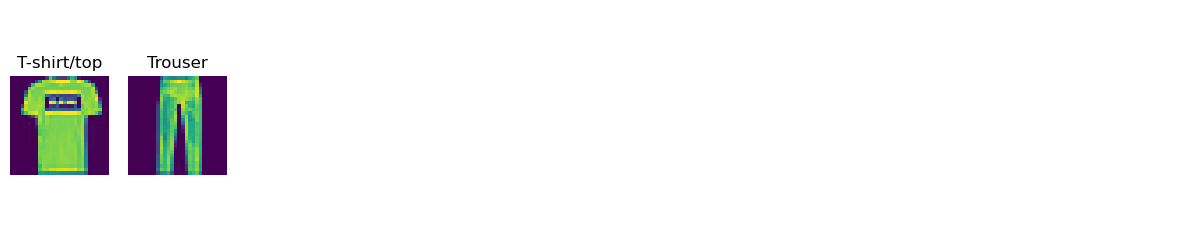

In [247]:
train_dataset, test_dataset = get_train_dataset(num_classes=2, max_images_per_class=100)
show_samples(train_dataset)

In [248]:
criterion = CrossEntropyLoss()/
for epoch in range(num_epochs):
    train_loop(train_dataset, model, criterion, print_log_freq, lr)

Train step 0, Loss: 0.00019, Acc: 0.0400, time: 0.4
Train step 25, Loss: 0.02705, Acc: 1.0000, time: 11.2
Train step 50, Loss: 0.02875, Acc: 1.0000, time: 11.4
Train step 75, Loss: 0.05460, Acc: 0.9600, time: 11.4
Train step 100, Loss: 0.01264, Acc: 1.0000, time: 11.7
Train step 125, Loss: 0.01281, Acc: 1.0000, time: 11.5
Train step 150, Loss: 0.01436, Acc: 1.0000, time: 11.2
Train step 175, Loss: 0.00505, Acc: 1.0000, time: 12.5
